# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

In [2]:
songs = pd.read_csv('https://raw.githubusercontent.com/MerleSt/SpotifyPlaylistMoosic/main/Data/song_fatures_cleaned.csv', index_col=[0,1])

In [3]:
songs.shape

(5235, 13)

# Columns to keep /drop from Scientific Literature and General Understanding


Certainly! Let's go through each of the features:

__Danceability__:

Recommendation: Keep.
Reason: Represents how suitable a track is for dancing based on various musical elements including tempo, rhythm stability, beat strength, and overall regularity.
Reference:
Jehan, T. (2005). Creating music by listening. PhD thesis, Massachusetts Institute of Technology.

__Energy__:

Recommendation: Keep.
Reason: Measures intensity and activity, typically energetic tracks feel fast and noisy.
Reference:
Tzanetakis, G., & Cook, P. (2002). Musical genre classification of audio signals. IEEE Transactions on speech and audio processing, 10(5), 293-302.

Key:

Recommendation: Depends.
Reason: While the key is fundamental in music theory, its efficacy in clustering tasks can be dataset dependent. However, it might be important when distinguishing between certain types of genres or moods.
Reference:
Mardirossian, G., & Chew, E. (2015). Key-independent multi-level tonal analysis for interactive music systems. In Proceedings of the ACM SIGCHI Conference on Human Factors in Computing Systems.

__Loudness__:

Recommendation: Keep but be cautious of its correlation with 'Energy'.
Reason: The perceived volume of the song can distinguish between certain moods or genres.
Reference:
Vickers, E. (2011). The loudness war: Background, speculation and recommendations. Audio Engineering Society Convention 131.

__Mode__:

Recommendation: Keep.
Reason: Major or minor mode can influence the mood or feel of a song.
Reference:
Huron, D. (2008). Sweet Anticipation: Music and the Psychology of Expectation. MIT Press.

__Speechiness__:

Recommendation: Keep.
Reason: Differentiates between talk shows, podcasts, and music.
Reference:
Mesaros, A., Heittola, T., Benetos, E., Foster, P., Lagrange, M., Virtanen, T., & Dixon, S. (2018). Detection and Classification of Acoustic Scenes and Events: Outcome of the DCASE 2016 Challenge. IEEE/ACM Transactions on Audio, Speech, and Language Processing.

__Acousticness__:

Recommendation: Keep.
Reason: Helps distinguish between electronic and acoustic music.
Reference:
Sturm, B. L., Diver, C., & Martinez, A. R. (2013). An evaluation of the audio feature space for detecting fake musical instrument samples.
In Proceedings of the Sound and Music Computing Conference.

__Instrumentalness__:

Recommendation: Keep.
Reason: Determines the presence of vocals in a song, distinguishing between purely instrumental tracks and those with lyrics.
Reference:
Leglaive, S., Hennequin, R., & Badeau, R. (2015). Singing voice detection with deep recurrent neural networks. In IEEE International Conference on Acoustics, Speech and Signal Processing.

__Liveness__:

Recommendation: Keep.
Reason: Identifies the presence of a live audience, differentiating studio recordings from live performances.
Reference:
Dittmar, C., & Müller, M. (2012). Automatic annotation of recorded music. In Multimodal Music Processing (Vol. 3).

__Valence__:

Recommendation: Keep.
Reason: Measures the musical positiveness of a track, can differentiate between moods.
Reference:
Yang, Y. H., & Chen, H. H. (2012). Machine recognition of music emotion: A review. ACM Transactions on Intelligent Systems and Technology (TIST), 3(3).

__Tempo__:

Recommendation: Keep.
Reason: The speed of a track is one of the fundamental aspects of music.
Reference:
Dixon, S. (2001). Automatic extraction of tempo and beat from expressive performances. Journal of New Music Research, 30(1), 39-58.

Duration_ms:

Recommendation: Consider.
Reason: The length of a track might not inherently convey much about its musical content, but it could be relevant depending on the dataset.
Reference:
Not commonly discussed in literature for its inherent musical properties.

Time_signature:

Recommendation: Depends.
Reason: Time signature can be critical for certain genres or analyzing complex rhythmic structures but might be less informative for general clustering tasks.
Reference:
Gouyon, F., Klapuri, A., Dixon, S., Alonso, M., Tzanetakis, G., Uhle, C., & Cano, P. (2006). An experimental comparison of audio tempo induction algorithms. IEEE Transactions on Audio, Speech, and Language Processing, 14(5), 1832-1844.

__DROP__
> time_signature, Duration_ms, Key

In [52]:
songs.drop(columns=['time_signature', 'duration_ms', 'key'], inplace = True)

# Scale

Since we found a few outliers in the data preprocessing operation, we need to either use a scalar, which corrects for this, drop the data, or use a model with weights. A combination of all of those is possible as well. 
1. Dropping all data is not an ideal solution, since there are too many outliers
2. A scalar to use here could be the RObust Scaler which corrects for outliers
3. Weights can be attricuted according to the distance to the centroid, hence, points further away have a lower weight in the clustering. This can be implemented in the K-means model. Since we will evaluate the model later on, we should not just decide on one strategy yet, but implement multiple and compare the results.

## Robust Scaler

In [54]:
# Define the scaler, use it and then transform the data into a dataframe again
scaler = RobustScaler()
songs_scaled = scaler.fit_transform(songs)
songs_robust = pd.DataFrame(songs_scaled, columns=songs.columns, index=songs.index)

In [55]:
songs_robust.shape

(5235, 10)

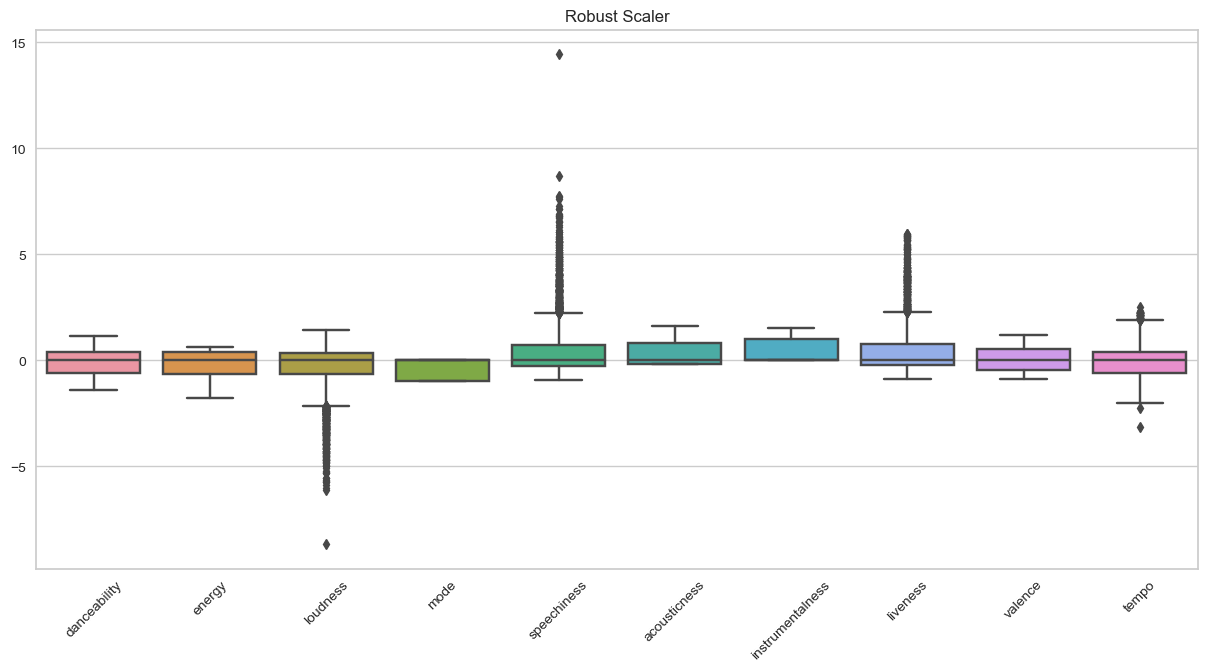

In [56]:
# Let us look at the outliers again
plt.figure(figsize=(15, 7))
sns.boxplot(data=songs_robust)
plt.title('Robust Scaler')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.show()

## MinMax Scaler

In [57]:
scaler = MinMaxScaler()
songs_scaled = scaler.fit_transform(songs)
songs_minmax = pd.DataFrame(songs_scaled, columns=songs.columns, index=songs.index)

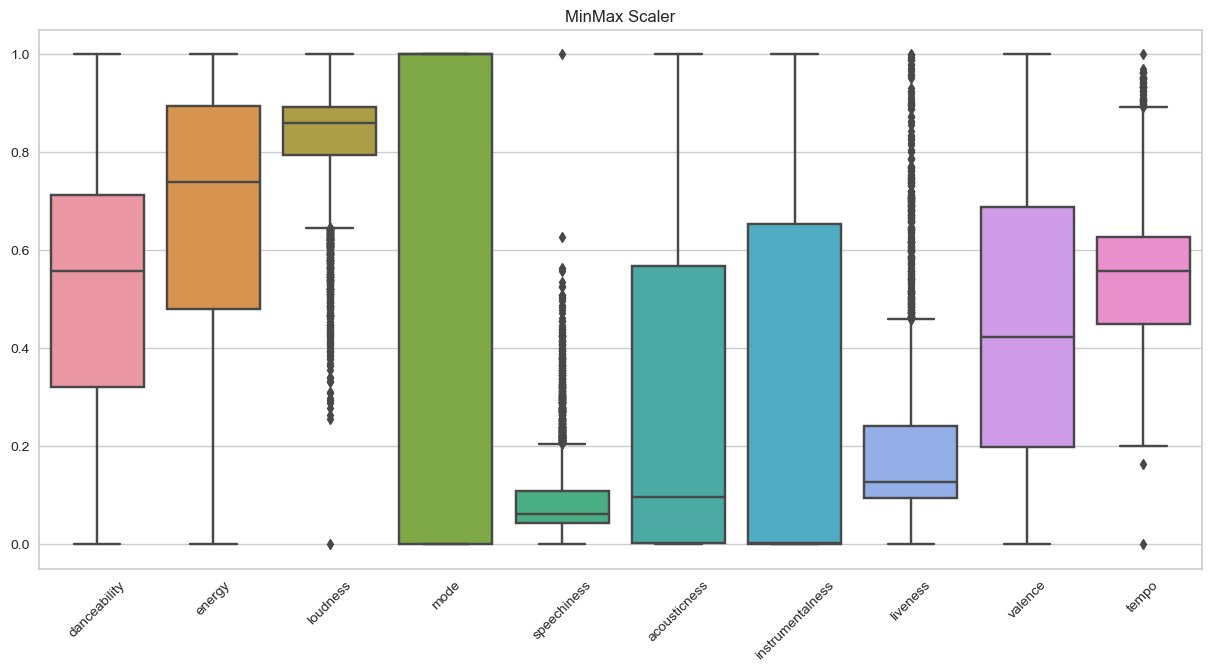

In [58]:
plt.figure(figsize=(15, 7))
sns.boxplot(data=songs_minmax)
plt.title('MinMax Scaler')
plt.xticks(rotation=45)  # Rotate x labels for better visibility
plt.show()

# Determine Number of Ks

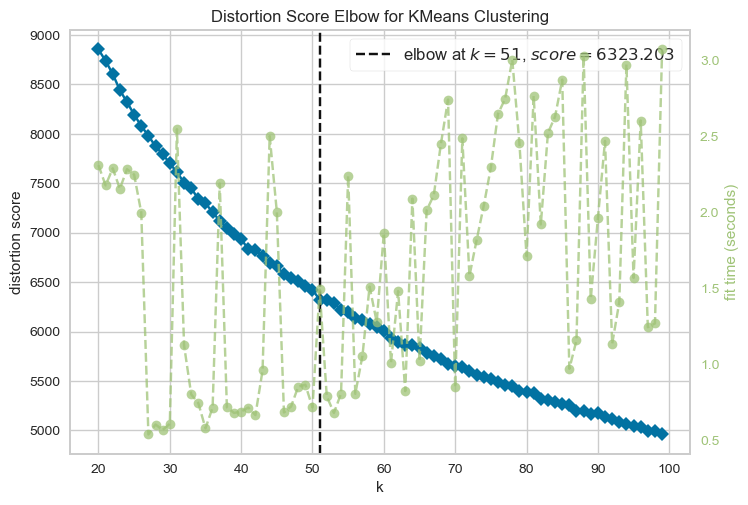

In [65]:
# Instantiate the clustering model and visualizer
model = KMeans(n_init=10, random_state=213)
visualizer = KElbowVisualizer(model, k=(20,100))

visualizer.fit(songs_robust)        # Fit the data to the visualizer
visualizer.show();

In [68]:
k_robust = visualizer.elbow_value_
print(f"The optimal number of clusters with a robust scaler is: {k_robust}")

The optimal number of clusters with a robust scaler is: 51


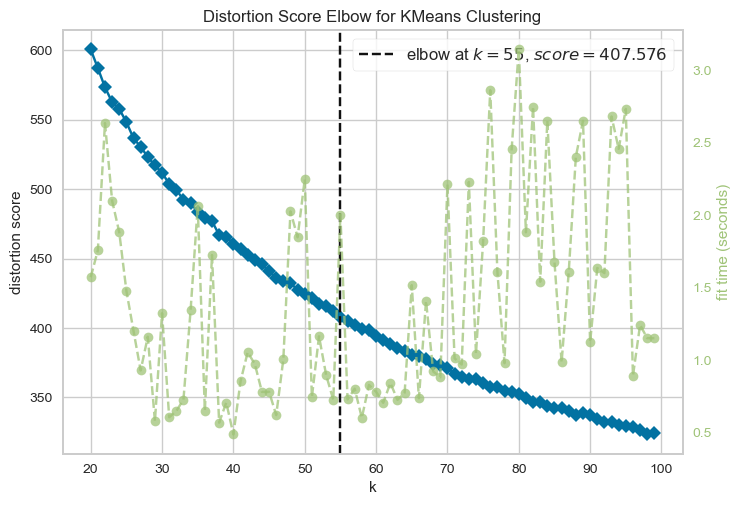

In [70]:
# Instantiate the clustering model and visualizer
model = KMeans(n_init=10, random_state=213)
visualizer = KElbowVisualizer(model, k=(20,100))

visualizer.fit(songs_minmax)        # Fit the data to the visualizer
visualizer.show();

In [71]:
k_minmax = visualizer.elbow_value_
print(f"The optimal number of clusters with the minmax scaler is: {k_minmax}")

The optimal number of clusters with the minmax scaler is: 55


# K-Means

Let's say you would prefer the MinMax Scaler since it makes readability and explanations easier, but you do not want to drop all outliers. Another idea would be to implement weights to the oberservations. The further an pbservation from their cluster, the lower their weight. 

In [14]:
# Step 1: Initial K-means run
kmeans = KMeans(n_init=10, n_clusters=k_minmax, random_state=213) # adjust the number of clusters as needed
kmeans.fit(songs_minmax)
initial_centroids = kmeans.cluster_centers_

# Step 2: Compute distance of each sample to its closest centroid
songs_array = songs_robust.to_numpy()  # Convert DataFrame to numpy array
n_samples = songs_array.shape[0]

# Using broadcasting to compute distances
expanded_songs = songs_array[:, np.newaxis, :]
expanded_centroids = initial_centroids[np.newaxis, :, :]
distances_all = np.linalg.norm(expanded_songs - expanded_centroids, axis=2)
distances = np.min(distances_all, axis=1)

# Step 3: Assign weights inversely proportional to distances 
weights = 1.0 / (distances + 1e-10)

# Now, you can use these weights in K-means
kmeans_weighted = KMeans(n_init=10, n_clusters=k_minmax, random_state=213)
clusters = kmeans_weighted.fit_predict(songs_robust, sample_weight=weights)

songs_minmax['cluster'] = clusters

In [16]:
songs_minmax

,,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,cluster
name,artist,,,,,,,,,,,,,,
Se Eu Quiser Falar Com Deus,Gilberto Gil,0.680455,0.25900,1.000000,0.763897,0.0,0.076797,0.696787,0.000060,0.987842,0.310660,0.515800,0.059067,0.8,8
Saudade De Bahia,Antônio Carlos Jobim,0.767322,0.39900,0.181818,0.771967,1.0,0.037691,0.217871,0.000002,0.108409,0.703553,0.584322,0.042058,0.8,0
"Canta Canta, Minha Gente",Martinho Da Vila,0.880041,0.73000,0.181818,0.798018,1.0,0.377996,0.454819,0.000064,0.125633,0.918782,0.437862,0.031590,0.8,4
Mulher Eu Sei,Chico César,0.729059,0.05020,0.363636,0.682811,1.0,0.051307,0.882530,0.000041,0.391084,0.531980,0.499098,0.040567,0.8,0
Rosa Morena,Kurt Elling,0.673216,0.11900,0.545455,0.655228,1.0,0.041394,0.919679,0.000348,0.105370,0.408122,0.565171,0.063684,0.8,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1812 Festival Overture, Op. 49: 1812 Overture, Op. 49",Pyotr Ilyich Tchaikovsky,0.208893,0.06940,0.272727,0.596818,1.0,0.051525,0.920683,0.725888,0.084296,0.066497,0.410795,0.254357,0.8,3
"Winter Fragments pour ensemble instrumental, sons de synthèse et dispositif électronique",Tristan Murail,0.194416,0.10100,0.545455,0.621548,1.0,0.048148,0.858434,0.432487,0.070314,0.036041,0.388495,0.217350,0.8,3
"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3 Farben (Colours)",Arnold Schoenberg,0.061634,0.00093,0.818182,0.277803,1.0,0.047277,0.954819,0.983756,0.078217,0.034924,0.334469,0.054302,0.6,10


## Normal K-Means

### Robust Scaler

In [85]:
kmeans = KMeans(n_init=10, n_clusters=k_robust, random_state=213)  # random_state for reproducibility
songs_robust['cluster'] = kmeans.fit_predict(songs_robust)

### MinMax Scaler

In [86]:
kmeans = KMeans(n_init=10, n_clusters=k_minmax, random_state=213)  # random_state for reproducibility
songs_minmax['cluster'] = kmeans.fit_predict(songs_minmax)

In [25]:
from sklearn_extra.cluster import KMedoids

# Assuming you have your data in a DataFrame called songs_robust, without the cluster column
data = songs_robust.drop(columns='cluster', errors='ignore')


# Initialize and fit the model
kmedoids = KMedoids(n_clusters=k, metric='euclidean', init='heuristic', random_state=213)
songs_robust['cluster'] = kmedoids.fit_predict(data)

In [26]:
# Step 1: Merge the dataframes
merged_df = songs_robust[['cluster']].merge(songs_minmax[['cluster']], left_index=True, right_index=True, suffixes=('_robust', '_minmax'))

# Step 2: Create a contingency table
contingency_table = pd.crosstab(merged_df['cluster_robust'], merged_df['cluster_minmax'])

# Display the table
print(contingency_table)

cluster_minmax   0    1    2   3    4    5    6    7    8    9    10
cluster_robust                                                      
0                 7    4  257  65    0   14    0    1    0    0    0
1                37  135   11   0   11    0   13  166    0   12    0
2                22  203    0   0    6  119   14   35    0    9    0
3                 3    0   25  11    0    0    0    0    1    0  493
4               343    0   11   0    0    0    0    2    0    0   63
5                 0    2    5   0  381    1    2    0   19    2    0
6                 0   11   35   0   30    0   14    3    0  718    0
7               121    2    0   0    0  144  160  211    0    1    0
8                12    1    4   0   41  139   34  316    0    3    0
9                28   13    9   0    1  265   93   23    0   52    0
10                4    1   17   1    0    0  254    1  197   23    0


Let me use the songs_robust clusters from the Robust K-Means with the Robust Scaler from here on.

Let us look at the correlation between features, as to decide whether we can drop columns and refine our model.

In [76]:
# Assuming songs_robust is your DataFrame
correlation_matrix = songs_robust[songs_robust.columns].corr()

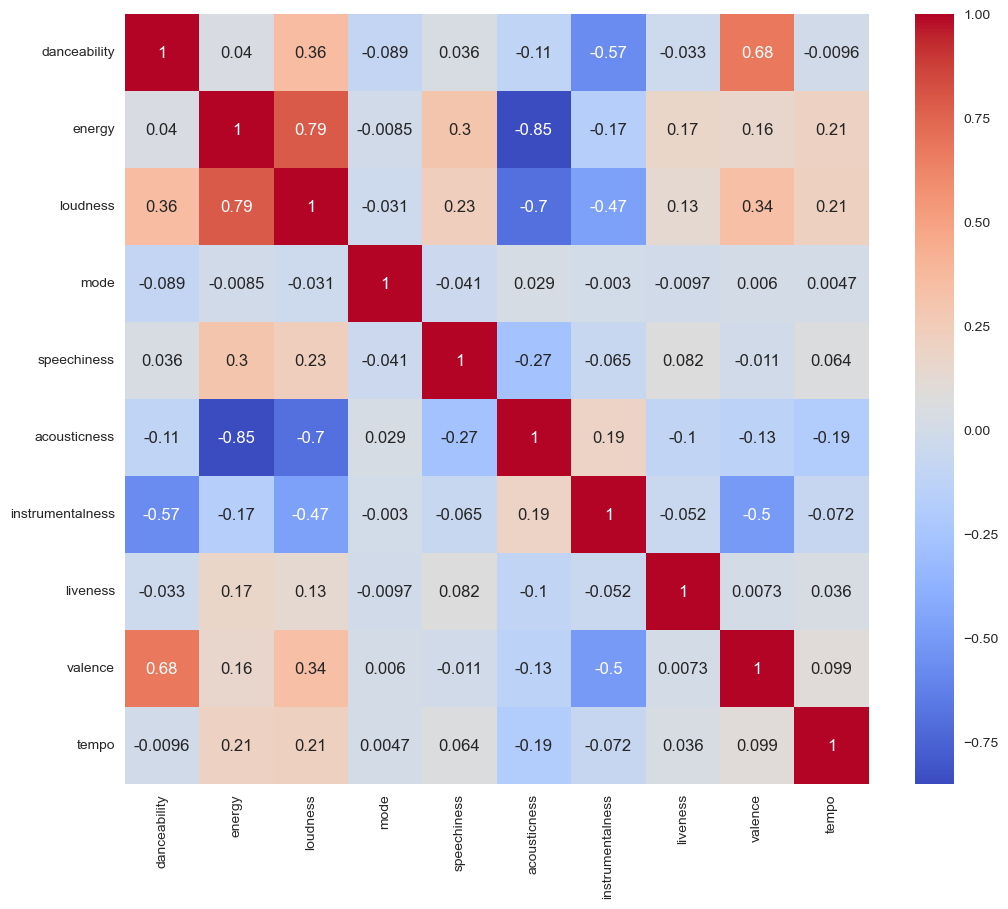

In [77]:
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Feature Importance

## Extra Trees Classifier

### Robust

In [87]:
# Tree model classifiers
songs_without_cluster = songs_robust.drop('cluster', axis=1)
tree_model = ExtraTreesClassifier().fit(songs_without_cluster, clusters)
feature_importance = tree_model.feature_importances_

ranked_features = [x for _, x in sorted(zip(feature_importance, songs_without_cluster.columns), reverse=True)]
print("Ranked Features:", ranked_features)

Ranked Features: ['liveness', 'speechiness', 'energy', 'acousticness', 'instrumentalness', 'danceability', 'tempo', 'loudness', 'valence', 'mode']


In [88]:
features_with_importance = sorted(list(zip(songs_without_cluster.columns, feature_importance)), key=lambda x: x[1], reverse=True)

for feature, importance in features_with_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: liveness, Importance: 0.1571553944788072
Feature: speechiness, Importance: 0.13808867503311467
Feature: energy, Importance: 0.11819235538341463
Feature: acousticness, Importance: 0.11702930904499047
Feature: instrumentalness, Importance: 0.10880631350952054
Feature: danceability, Importance: 0.09840869584570724
Feature: tempo, Importance: 0.09361046688642198
Feature: loudness, Importance: 0.07855979358824638
Feature: valence, Importance: 0.07162972662047025
Feature: mode, Importance: 0.018519269609306468


### MinMax

In [89]:
# Tree model classifiers
songs_without_cluster = songs_minmax.drop('cluster', axis=1)
tree_model = ExtraTreesClassifier().fit(songs_without_cluster, clusters)
feature_importance = tree_model.feature_importances_

ranked_features = [x for _, x in sorted(zip(feature_importance, songs_without_cluster.columns), reverse=True)]
print("Ranked Features:", ranked_features)

Ranked Features: ['liveness', 'speechiness', 'acousticness', 'energy', 'instrumentalness', 'danceability', 'tempo', 'loudness', 'valence', 'mode']


In [90]:
features_with_importance = sorted(list(zip(songs_without_cluster.columns, feature_importance)), key=lambda x: x[1], reverse=True)

for feature, importance in features_with_importance:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: liveness, Importance: 0.15498193796617823
Feature: speechiness, Importance: 0.1401255498519584
Feature: acousticness, Importance: 0.1234560691895558
Feature: energy, Importance: 0.1160552612905875
Feature: instrumentalness, Importance: 0.10369002782064847
Feature: danceability, Importance: 0.0981870724275458
Feature: tempo, Importance: 0.09250406091562309
Feature: loudness, Importance: 0.08053647191353523
Feature: valence, Importance: 0.0716028070576893
Feature: mode, Importance: 0.018860741566678073


## Correlation Matrix of Features

Let us look at the correlation between features, as to decide whether we can drop columns and refine our model.

In [95]:
# Assuming songs_robust is your DataFrame
songs_cluster = songs_minmax.drop('cluster', axis=1)
correlation_matrix = songs_cluster[songs_cluster.columns].corr()

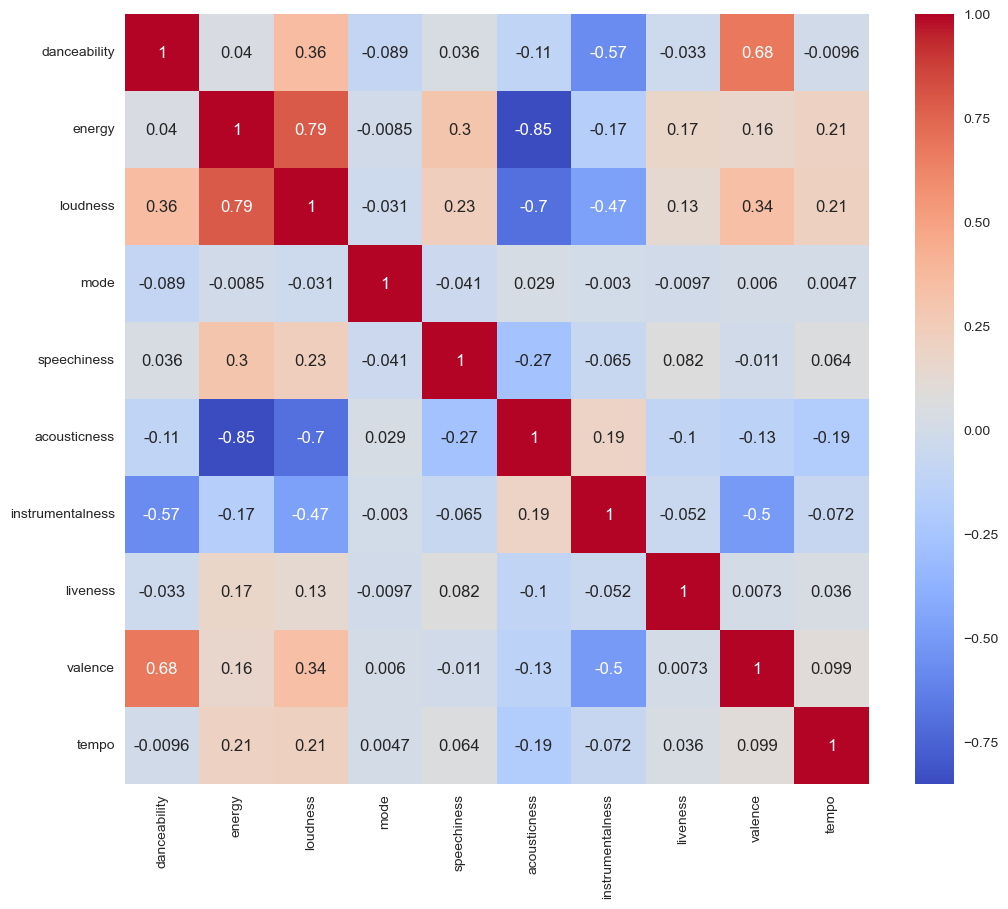

In [96]:
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Evaluating the Model

## Silhouette Score

Definition: The Silhouette Score measures how close each point in one cluster is to the points in the neighboring clusters.

Silhouette Score:
Range: The silhouette score ranges from -1 to 1.

Interpretation:

- Near +1: The clusters are well apart from each other and clearly distinguished.
- 0: The clusters are overlapping and there is considerable intermingling.
- Near -1: Points have been assigned to the wrong clusters.

General Guideline:

over 0.7: A strong structure has been found.

0.5 - 0.7: A reasonable structure has been found.

0.25 - 0.5: The structure is weak and could be artificial. Try additional cluster evaluation metrics and techniques.

< 0.25: No substantial structure has been found.

In [97]:
# Assume kmeans is your clustering model and X is your data
score = silhouette_score(songs_robust, kmeans.labels_, random_state=213)
print("Silhouette Score: ", score)

Silhouette Score:  -0.3482157000531676


In [98]:
# Assume kmeans is your clustering model and X is your data
score = silhouette_score(songs_minmax, kmeans.labels_, random_state=213)
print("Silhouette Score: ", score)

Silhouette Score:  0.7422483906028768


## Davies-Bouldin Index

The Davies-Bouldin index signifies the average 'similarity' ratio of each cluster with its most similar cluster. Here, 'similarity' is a measure that compares the distance between clusters with the size of the clusters themselves.

Range: The DB index values start from 0 and can be infinite.

Interpretation:

- Lower values: Indicate better clustering. Ideally, you want the DB index to be as close to 0 as possible.
- Higher values: Indicate that the clusters are less dense and/or more separated.

General Guideline:

As with any heuristic, there's no strict threshold for a "good" DB index value because it largely depends on the dataset. Still, lower is better. If you try different clustering configurations or algorithms, you'd prefer the one with a lower DB index over others.

In [99]:
# Assume kmeans is your clustering model and X is your data
db_score = davies_bouldin_score(songs_robust, kmeans.labels_)
print("Davies-Bouldin Index: ", db_score)

Davies-Bouldin Index:  13.228061619274525


In [100]:
# Assume kmeans is your clustering model and X is your data
db_score = davies_bouldin_score(songs_minmax, kmeans.labels_)
print("Davies-Bouldin Index: ", db_score)

Davies-Bouldin Index:  0.413479869156366


The best model so far is the Normal K-Means using the MinMax Scaler

# Improving the Model